###  Įterpiamos reikiamos bibliotekos:

In [218]:
%matplotlib inline

import numpy as np
from typing import Callable
import matplotlib.pyplot as plt
import matplotlib.axes as ax

###  Dirbtinis neuronas

Pagrindinė funkcija svoriams gauti - `get_weights(...)`.


`weights` generuojami atsitiktinai iš duoto intervalo. Jei randamas toks svorių rinkinys,
kur su visomis įvestimis prognozės atitinka norimas išvestis, programa ciklas nutraukiamas ir
funkcija grąžina to rinkinio reikšmes.

### Duomenų užkrovimo modulis
Klasė `DataModule` skirta užkrauti duomenims iš failo. 

`feature_range` nurodo, kuriuos bruožus įtraukti į rinkinį.
Pavyzdžiui, jei identifikacijos numeris yra pirmas bruožas, norėsime jį išmesti.


`target_index` žymi trokštamos reikšmės indeksą failo eilutėje.


`split_rate` - nurodo, kurią dalį sudarys treniravimo duomenys. Likę duomenys bus skirti validavimui.

Pastaba: duomenų tvarka yra išmaišoma nei yra faile. Kad išmaišymas visada būtų vienodas, naudojama `np.random.seed(1)`.

In [219]:
class DataModule():
    def __init__(self, feature_range, target_index,
                 filepath, split_rate = 0.8):
        self.feature_count = feature_range[1] - feature_range[0]
        
        with open(filepath) as file:
            raw_data = [line.rstrip().split(",") for line in file]
            
        raw_data = np.array(raw_data)
        
        np.random.seed(1)
        np.random.shuffle(raw_data)
        np.random.seed()
    
        self.features = raw_data[:, feature_range[0] : feature_range[1]].astype(np.float32)
        self.targets = raw_data[:, target_index].astype(np.float32)
        
        self.training_count = int(len(raw_data) * split_rate)
      
        
    def get_training_data(self):
        return self.features[:self.training_count], self.targets[:self.training_count]
    
    
    def get_validation_data(self):
        return self.features[self.training_count:], self.targets[self.training_count:]

#### Aktyvacijos funkcijos

In [220]:
def binary_step_function(value) -> int:
    return 1 if value >= 0 else 0

def sigmoid_step_function(value) -> int:
    return 1 / (1 + np.exp(-1 * value))

### Modelis(Perceptronas)

Nurodoma aktyvacijos funkcija, kurią naudos modelis (naudoti apibrėžtas pavyzdyje).

`num_inputs` - žymi požymių skaičių. Atitinkamai tiek pat bus sugeneruotų svorių reikšmių, atsitiktinai
pagal Gauso skirstinį su iš anksto numatytom reikšmėm `mean` = 0 ir `sd` = 1.

`learning_rate` - kontroliuoja mokymosi greitį.

`adjust_weights(...)` - naudojama ADALINE mokymo taisyklė.

In [221]:
class Perceptron():
    def __init__(self, /,
                 activation_function: Callable[[list[float], list[float]], int],
                 num_inputs: int, learning_rate: float,
                 mean = 0, sd = 1):
        self.weights = np.random.normal(mean, sd, num_inputs)
        self.bias = np.random.normal(mean, sd, 1)[0]
        self.activation_function = activation_function
        self.learning_rate = learning_rate
        
        print('Pradiniai svoriai: ', self.weights, '\n', "Pradinis poslinkis: ", self.bias)
    
    
    def forward(self, features):
        lin_regression = np.dot(self.weights, features) + self.bias
        return self.activation_function(lin_regression)
    
    
    def adjust_weights(self, features, target, prediction):
        self.weights += self.learning_rate * features * (target - prediction)
        self.bias += self.learning_rate * (target - prediction)
    
    
    def loss(self, targets, predictions):
        return(targets - predictions) ** 2 / 2
    
    
    def __call__(self, features):
        return self.forward(features)

### Treniravimo klasė
Klasė, kuri skirta treniruoti modelį, braižyti grafiką ir skaičiuoti elementarias statistikas. 

Mokymas vyksta `fit_epoch(...)` funkcijoje, pasitelkiant `model.adjust_weights(...)` aprašytą aukščiau.

In [222]:
class Trainer():
    def __init__(self) -> None:
        self.figure, self.axis = plt.subplots(2,2, figsize=(14,6))
        
        plt.subplots_adjust(
           left=0.1,
           bottom=0.1,
           right=0.9,
           top=0.9,
           wspace=0.2,
           hspace=0.6)
        

        for axis in self.axis.flat:
            axis.set(xlabel= 'Epochų skaičius', ylabel= 'Reiškmė')
    
        self.training_accuracies = []
        self.training_losses = []
        self.validation_accuracies = []
        self.validation_losses = []
        self.epochs = []


    def is_equal(self, target, prediction):
        prediction = 1 if prediction >= 0.5 else 0
        return target == prediction 
    
    def draw_graphs(self, accuracy, loss, train):
        axis = self.axis
        
                
        if train:
            self.training_accuracies.append(accuracy)
            self.training_losses.append(loss)
            
            axis[0, 0].plot(self.epochs, self.training_accuracies, 'tab:cyan')
            axis[0, 0].set_title('Treniravimo tikslumas')
            axis[0, 1].plot(self.epochs, self.training_losses, 'tab:pink')
            axis[0, 1].set_title('Treniravimo nuostolių funkcija')
        else:
            self.validation_accuracies.append(accuracy)
            self.validation_losses.append(loss)
            
            axis[1, 0].plot(self.epochs, self.validation_accuracies, 'tab:purple')
            axis[1, 0].set_title('Validavimo tikslumas')
            axis[1, 1].plot(self.epochs, self.validation_losses, 'tab:olive')
            axis[1, 1].set_title('Validavimo nuostolių funkcija')

    
    def fit_epoch(self, model: Perceptron, data_module: DataModule, train = False):
        predictions = np.array([])
        data = data_module.get_training_data() if train else data_module.get_validation_data()
        example_count = len(data[0])
        truths = example_count
        
        for (features, target) in zip(data[0], data[1]):
            prediction = model(features)
            predictions = np.append(predictions, prediction)
            
            if not self.is_equal(target, prediction):
                truths -= 1
                if train:
                    model.adjust_weights(features, target, prediction)
                
        accuracy = truths / example_count
        loss = model.loss(data[1], predictions).sum()
        
        self.draw_graphs(accuracy, loss, train)
        
    
    def train(self, model: Perceptron, data, epoch_count):
        for epoch_number in range(1, epoch_count + 1):
            self.epochs.append(epoch_number)
            self.fit_epoch(model, data, train = True)
            self.fit_epoch(model, data, train = False)

### Modelio mokymas
Modelio mokymas su duomenimis naudojant sigmoidinę ir slenkstinę aktyvacijos funkcijas.

Pradiniai svoriai:  [-0.91345262  1.55194706 -1.22304626 -0.24632355 -0.69197017 -0.91074978
 -0.68655967  2.08359841 -0.81823663] 
 Pradinis poslinkis:  0.7824646543820413


Galutiniai svoriai: [  98.89727736 1401.07953495  798.39877991 1999.51743988 -200.88105708
 1899.0417191   698.84096719 1702.03606728  399.13441535] 
 Galutinis poslinkis: -15499.264795365316 

 Paskutinė (treniravimo) nuostolių funkcijos reikšmė: 17.5 
 Paskutinė (treniravimo) tikslumo reikšmė 0.9358974358974359 
 Paskutinė (validavimo) nuostolių funkcijos reikšmė: 7.0 
 Paskutinė (validavimo) tikslumo reikšmė: 0.8978102189781022 
 Epochų skaičius: 10 
 Mokymosi greitis: 100 

Požymiai: [3. 1. 1. 1. 2. 1. 2. 1. 1.] 	 nustatė: 0 turėjo būti: 0 

Požymiai: [1. 1. 1. 1. 3. 1. 1. 1. 1.] 	 nustatė: 0 turėjo būti: 0 

Požymiai: [ 8.  4.  4.  1.  6. 10.  2.  5.  2.] 	 nustatė: 1 turėjo būti: 1 

Požymiai: [ 8. 10. 10.  8.  6.  9.  3. 10. 10.] 	 nustatė: 1 turėjo būti: 1 

Požymiai: [3. 2. 2. 3. 2. 3. 3. 1. 1.] 	 nustatė

/tmp/ipykernel_17211/645481291.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-1 * value))


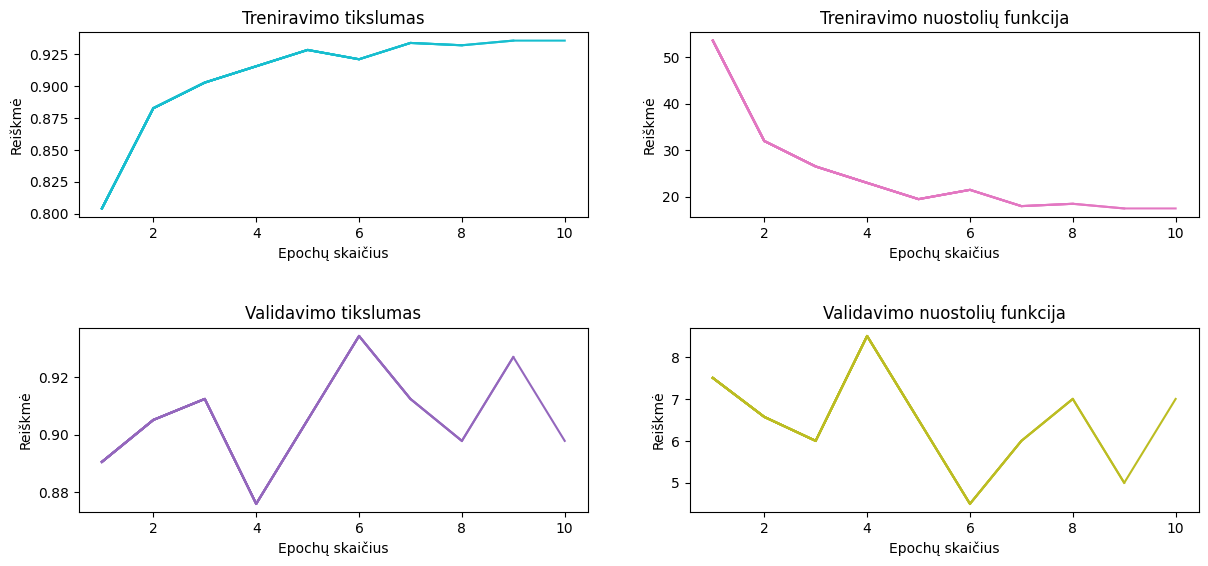

In [356]:
epoch_count = 10
learning_rate = 100


data = DataModule(feature_range=(1, 10), target_index= 10, filepath='Resources/breast-cancer-wisconsin.data')
model1 = Perceptron(activation_function= sigmoid_step_function, num_inputs = data.feature_count, learning_rate= learning_rate)
#model1.weights = np.array([ 0.13709586 ,-0.55403839,  0.57785245,  1.23289373,  1.39808058,  0.19744986, 0.92987133, -1.9186774,  -1.29364997])
#model1.bias = 0.32882730642787983
trainer = Trainer()
trainer.train(model1, data, epoch_count=epoch_count)

print('\n\nGalutiniai svoriai:', model1.weights, '\n', 'Galutinis poslinkis:', model1.bias, '\n\n',
      'Paskutinė (treniravimo) nuostolių funkcijos reikšmė:', trainer.training_losses[-1], '\n',
      'Paskutinė (treniravimo) tikslumo reikšmė', trainer.training_accuracies[-1], '\n',
      'Paskutinė (validavimo) nuostolių funkcijos reikšmė:', trainer.validation_losses[-1], '\n',
      'Paskutinė (validavimo) tikslumo reikšmė:', trainer.validation_accuracies[-1], '\n',
      'Epochų skaičius:', epoch_count, '\n',
      'Mokymosi greitis:', learning_rate, '\n')

validations_data = data.get_validation_data()
for (features, target) in zip(validations_data[0], validations_data[1]):
      prediction = 1 if model1(features) >= 0.5 else 0
      print("Požymiai:", features, "\t nustatė:", prediction, "turėjo būti:", int(target), '\n')

Pradiniai svoriai:  [ 0.13463619  0.9146811   1.07392225 -0.53278356 -0.90895437  0.19787951
 -2.00194409  0.25906371 -0.90634494] 
 Pradinis poslinkis:  1.6748476574740436


Galutiniai svoriai: [199980.13463619   9999.9146811  189982.07392225  39995.46721644
  -9999.90895437 139986.19787951 139983.99805591 259974.25906371
 229976.09365506] 
 Galutinis poslinkis: -3639634.3251523427 

 Paskutinė (treniravimo) nuostolių funkcijos reikšmė: 12.5 
 Paskutinė (treniravimo) tikslumo reikšmė 0.9542124542124543 
 Paskutinė (validavimo) nuostolių funkcijos reikšmė: 2.0 
 Paskutinė (validavimo) tikslumo reikšmė: 0.9708029197080292 
 Epochų skaičius: 100 
 Mokymosi greitis: 9999 

Požymiai: [3. 1. 1. 1. 2. 1. 2. 1. 1.] 	 nustatė: 0 turėjo būti: 0 

Požymiai: [1. 1. 1. 1. 3. 1. 1. 1. 1.] 	 nustatė: 0 turėjo būti: 0 

Požymiai: [ 8.  4.  4.  1.  6. 10.  2.  5.  2.] 	 nustatė: 1 turėjo būti: 1 

Požymiai: [ 8. 10. 10.  8.  6.  9.  3. 10. 10.] 	 nustatė: 1 turėjo būti: 1 

Požymiai: [3. 2. 2. 3. 2. 3

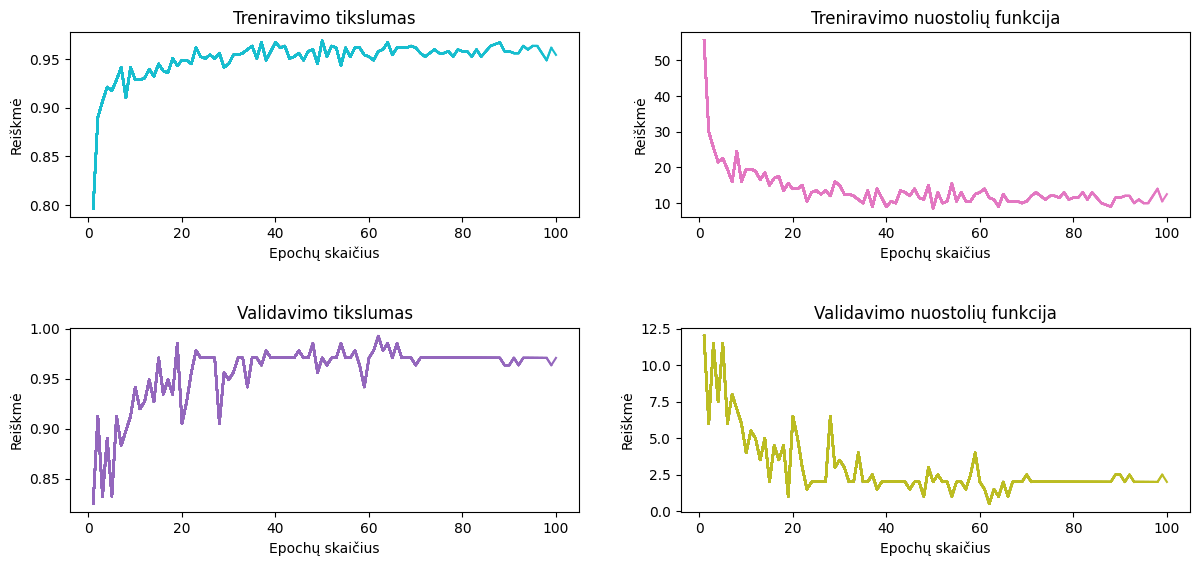

In [354]:
epoch_count = 100
learning_rate = 9999

model2 = Perceptron(activation_function= binary_step_function, num_inputs = data.feature_count, learning_rate= learning_rate)
#model2.weights = np.array([-0.043214,    0.09631218,  1.59749039, -1.50894108 , 1.37445284 , 0.49807289 ,0.82484865 , 0.56262489 ,-0.96140759] )
#model2.bias = -0.9189004365217152
trainer = Trainer()
trainer.train(model2, data, epoch_count=epoch_count)

print('\n\nGalutiniai svoriai:', model2.weights, '\n', 'Galutinis poslinkis:', model2.bias, '\n\n',
      'Paskutinė (treniravimo) nuostolių funkcijos reikšmė:', trainer.training_losses[-1], '\n',
      'Paskutinė (treniravimo) tikslumo reikšmė', trainer.training_accuracies[-1], '\n',
      'Paskutinė (validavimo) nuostolių funkcijos reikšmė:', trainer.validation_losses[-1], '\n',
      'Paskutinė (validavimo) tikslumo reikšmė:', trainer.validation_accuracies[-1], '\n',
      'Epochų skaičius:', epoch_count, '\n',
      'Mokymosi greitis:', learning_rate, '\n')

validations_data = data.get_validation_data()
for (features, target) in zip(validations_data[0], validations_data[1]):
      prediction = 1 if model2(features) >= 0.5 else 0
      print("Požymiai:", features, "\t nustatė:", prediction, "turėjo būti:", int(target), '\n')

Pradiniai svoriai:  [-0.13528843 -0.59701631 -0.37591701 -0.2485996 ] 
 Pradinis poslinkis:  0.07490464167751414


Galutiniai svoriai: [-3293417.64963815 -1451292.0627958   3737117.53324877  4329070.23001886] 
 Galutinis poslinkis: -1700449.2733342042 

 Paskutinė (treniravimo) nuostolių funkcijos reikšmė: 7.5 
 Paskutinė (treniravimo) tikslumo reikšmė 0.8125 
 Paskutinė (validavimo) nuostolių funkcijos reikšmė: 1.0 
 Paskutinė (validavimo) tikslumo reikšmė: 0.9 
 Epochų skaičius: 10 
 Mokymosi greitis: 99999 

Požymiai: [5.7 2.6 3.5 1. ] 	 nustatė: 0 turėjo būti: 0 

Požymiai: [6.  2.9 4.5 1.5] 	 nustatė: 0 turėjo būti: 0 

Požymiai: [5.9 3.  4.2 1.5] 	 nustatė: 0 turėjo būti: 0 

Požymiai: [6.2 2.2 4.5 1.5] 	 nustatė: 0 turėjo būti: 0 

Požymiai: [5.9 3.2 4.8 1.8] 	 nustatė: 0 turėjo būti: 0 

Požymiai: [6.3 3.3 6.  2.5] 	 nustatė: 1 turėjo būti: 1 

Požymiai: [6.6 3.  4.4 1.4] 	 nustatė: 0 turėjo būti: 0 

Požymiai: [6.3 3.3 4.7 1.6] 	 nustatė: 0 turėjo būti: 0 

Požymiai: [5.6 2.8 

/tmp/ipykernel_17211/645481291.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-1 * value))


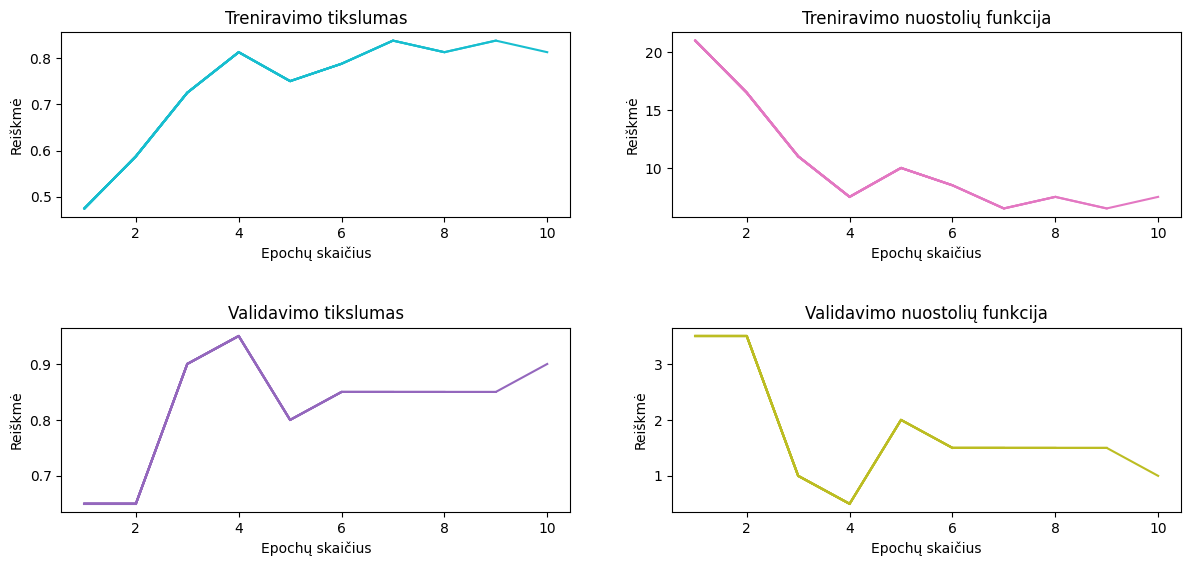

In [353]:
epoch_count = 10
learning_rate = 99999


data2 = DataModule(feature_range=(0, 4), target_index= 4, filepath='Resources/iris.data')
model3 = Perceptron(activation_function= sigmoid_step_function, num_inputs = data2.feature_count, learning_rate= learning_rate)
#model3.weights = np.array([ 0.27179536, -0.45385069 , 0.267792  ,  0.03030674] )
#model3.bias =  -2.0762719391098314
trainer = Trainer()
trainer.train(model3, data2, epoch_count=epoch_count)

print('\n\nGalutiniai svoriai:', model3.weights, '\n', 'Galutinis poslinkis:', model3.bias, '\n\n',
      'Paskutinė (treniravimo) nuostolių funkcijos reikšmė:', trainer.training_losses[-1], '\n',
      'Paskutinė (treniravimo) tikslumo reikšmė', trainer.training_accuracies[-1], '\n',
      'Paskutinė (validavimo) nuostolių funkcijos reikšmė:', trainer.validation_losses[-1], '\n',
      'Paskutinė (validavimo) tikslumo reikšmė:', trainer.validation_accuracies[-1], '\n',
      'Epochų skaičius:', epoch_count, '\n',
      'Mokymosi greitis:', learning_rate, '\n')

validations_data = data2.get_validation_data()
for (features, target) in zip(validations_data[0], validations_data[1]):
      prediction = 1 if model3(features) >= 0.5 else 0
      print("Požymiai:", features, "\t nustatė:", prediction, "turėjo būti:", int(target), '\n')

Pradiniai svoriai:  [-0.88813691 -0.96001405  0.40297823 -1.99854308] 
 Pradinis poslinkis:  0.12639234987306772


Galutiniai svoriai: [-0.544637   -0.57271401  1.34897827 -0.86804305] 
 Galutinis poslinkis: 0.025392349873067627 

 Paskutinė (treniravimo) nuostolių funkcijos reikšmė: 10.0 
 Paskutinė (treniravimo) tikslumo reikšmė 0.75 
 Paskutinė (validavimo) nuostolių funkcijos reikšmė: 3.0 
 Paskutinė (validavimo) tikslumo reikšmė: 0.7 
 Epochų skaičius: 100 
 Mokymosi greitis: 0.001 

Požymiai: [5.7 2.6 3.5 1. ] 	 nustatė: 0 turėjo būti: 0 

Požymiai: [6.  2.9 4.5 1.5] 	 nustatė: 0 turėjo būti: 0 

Požymiai: [5.9 3.  4.2 1.5] 	 nustatė: 0 turėjo būti: 0 

Požymiai: [6.2 2.2 4.5 1.5] 	 nustatė: 1 turėjo būti: 0 

Požymiai: [5.9 3.2 4.8 1.8] 	 nustatė: 0 turėjo būti: 0 

Požymiai: [6.3 3.3 6.  2.5] 	 nustatė: 1 turėjo būti: 1 

Požymiai: [6.6 3.  4.4 1.4] 	 nustatė: 0 turėjo būti: 0 

Požymiai: [6.3 3.3 4.7 1.6] 	 nustatė: 0 turėjo būti: 0 

Požymiai: [5.6 2.8 4.9 2. ] 	 nustatė: 1 t

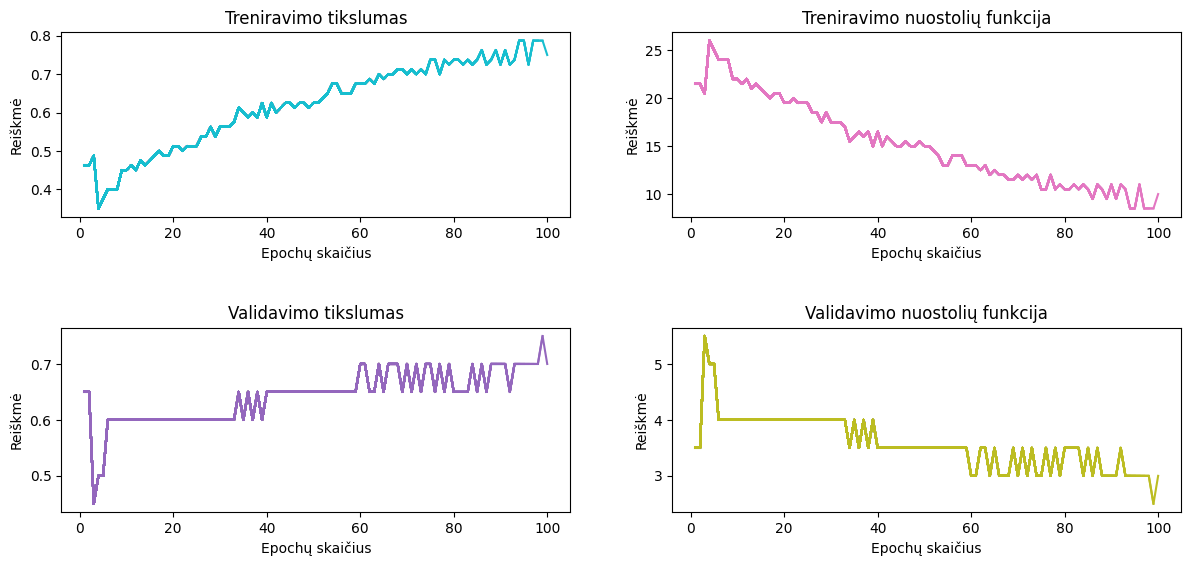

In [226]:
epoch_count = 100
learning_rate = 0.001


model4 = Perceptron(activation_function= binary_step_function, num_inputs = data2.feature_count, learning_rate= learning_rate)
# model4.weights = np.array([-1.02607258 , 0.52098422 ,-1.66100759 ,-0.47327743] )
# model4.bias = -1.0519975387565073
trainer = Trainer()
trainer.train(model4, data2, epoch_count=epoch_count)

print('\n\nGalutiniai svoriai:', model4.weights, '\n', 'Galutinis poslinkis:', model4.bias, '\n\n',
      'Paskutinė (treniravimo) nuostolių funkcijos reikšmė:', trainer.training_losses[-1], '\n',
      'Paskutinė (treniravimo) tikslumo reikšmė', trainer.training_accuracies[-1], '\n',
      'Paskutinė (validavimo) nuostolių funkcijos reikšmė:', trainer.validation_losses[-1], '\n',
      'Paskutinė (validavimo) tikslumo reikšmė:', trainer.validation_accuracies[-1], '\n',
      'Epochų skaičius:', epoch_count, '\n',
      'Mokymosi greitis:', learning_rate, '\n')

validations_data = data2.get_validation_data()
for (features, target) in zip(validations_data[0], validations_data[1]):
      prediction = 1 if model4(features) >= 0.5 else 0
      print("Požymiai:", features, "\t nustatė:", prediction, "turėjo būti:", int(target), '\n')